<a href="https://colab.research.google.com/github/leekh8/Colaboratory/blob/main/ex16_%EC%95%84%EA%B8%B0_%EC%9A%B8%EC%9D%8C%EC%86%8C%EB%A6%AC_%EB%B6%84%EB%A5%98.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 학습 목표
- 소리 데이터를 처리/분석하는 방법을 학습한다.
- 아기 울음소리 분류하는 방법을 학습한다
 - wav 데이터와 Dense층만 활용
 - wav 데이터와 Cinc1D 층을 활용
 - mfcc 데이터와 Con2D 층을 활용

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/MyDrive/Colab Notebooks/Colaboratory/AISchool/'

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks/Colaboratory/AISchool


# unzip data

In [ ]:
import zipfile

zip_dir = './Data/baby_sound.zip'

zip_ref = zipfile.ZipFile(zip_dir, 'r')
zip_ref.extractall('./Data')
zip_ref.close()

# install librosa library

In [2]:
!pip install librosa

# print .wav file

In [3]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import IPython.display

DATA_DIR = './Data/'

# read sound file
# wav: sound data array
# sr : sampling rate (data / sec)
wav, sr = librosa.load(DATA_DIR + "test_voice.wav")

print(f"sr\t\t\t: \t{sr}")
print(f"data size\t: \t{wav.shape}")
print(f"play time\t: \t{wav.shape[0] / float(sr)} \tseconds")

sr			: 	22050
data size	: 	(67253,)
play time	: 	3.0500226757369613 	seconds


# play

In [4]:
IPython.display.Audio(data = wav, rate = sr)

# data visualizing

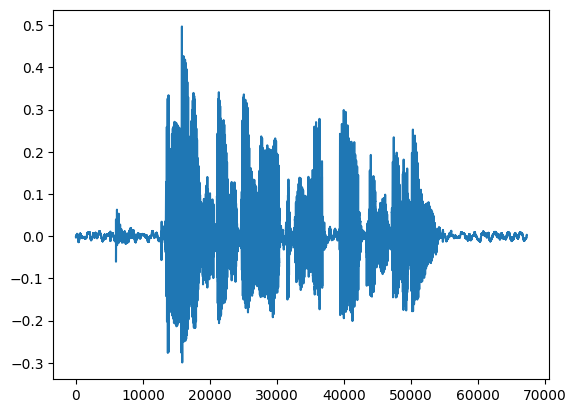

In [5]:
plt.plot(wav)
plt.show()

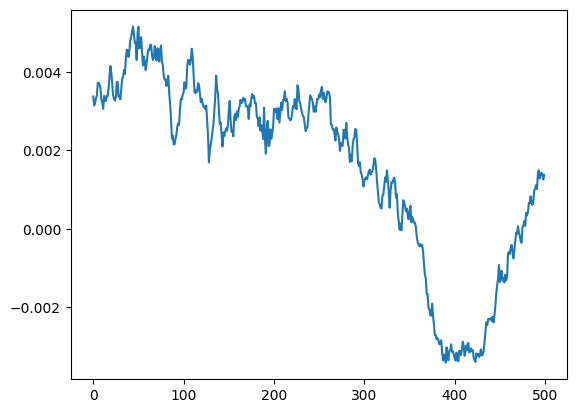

In [6]:
plt.plot(wav[10000:10500])
plt.show()

# 진폭 데이터를 주파수 데이터로 변환
  - 진폭 데이터에는 충분한 소리의 특성 담기 어렵기 때문

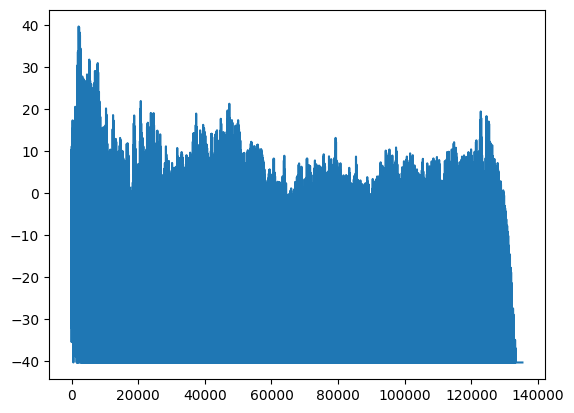

In [7]:
# amplitude_to_db: 진폭 -> 데시벨
# stft(): 진폭 -> 주파수 : short time fourier transform
dB = librosa.amplitude_to_db(np.abs(librosa.stft(wav)))

plt.plot(dB.flatten())
plt.show()

/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=500
  warnings.warn(


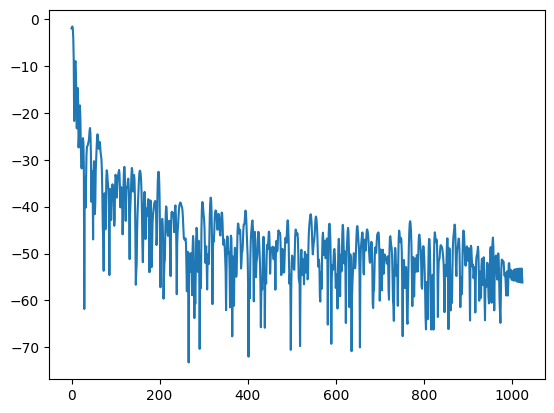

In [8]:
dB2 = librosa.amplitude_to_db(np.abs(librosa.stft(wav[10000:10500])))

plt.plot(dB2.flatten())
plt.show()

# 인간의 귀는 고주파보다 저주파를 잘 인식
  - 저주파 -> sampling 많이
  - 고주파 -> sampling 적게
    
    => **Melspectrogram**

In [9]:
# 주파수 성분 -> Melspectrogram
# n_mels: y축의 눈금 수 (Melspectrogram의 값을 몇 개로 분리할 것인지)
S = librosa.feature.melspectrogram(y = wav, sr = sr, n_mels = 128)

print(S.shape)

(128, 132)


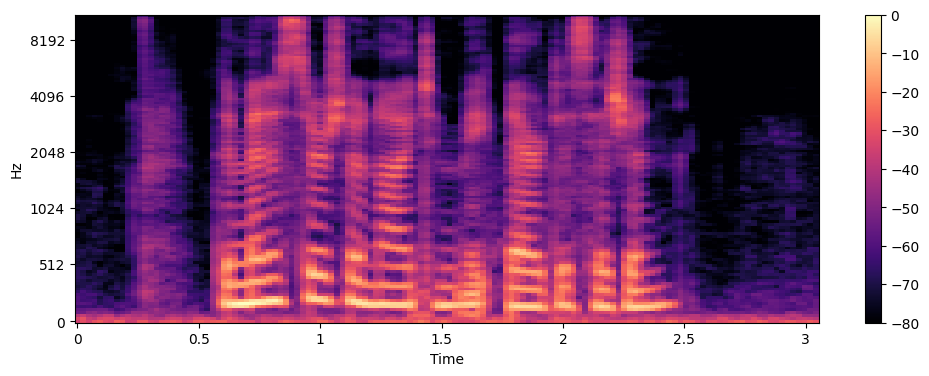

In [10]:
# data visualizing
log_S = librosa.power_to_db(S, ref = np.max)

plt.figure(figsize = (12, 4))
librosa.display.specshow(log_S, sr = sr, x_axis = 'time', y_axis = 'mel' )
plt.colorbar()
plt.show()

# MFCC
  - Melspectrogram을 디지털화

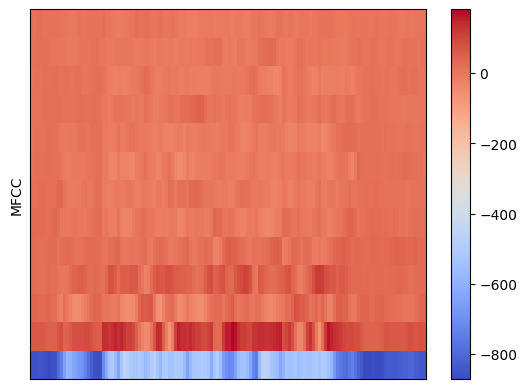

In [11]:
# n_mfcc: 세로축의 눈금수
mfcc = librosa.feature.mfcc(S = log_S, n_mfcc = 13)

librosa.display.specshow(mfcc)
plt.ylabel("MFCC")
plt.colorbar()
plt.show()

# STT (Speech to Text)
  - sound -> text

In [12]:
!pip install SpeechRecognition

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.8/32.8 MB 48.6 MB/s eta 0:00:00


In [13]:
import speech_recognition as speech

recognizer = speech.Recognizer()

wav_file = speech.AudioFile('./Data/test_voice.wav')

# read wav file and save
with wav_file as w:
  wav = recognizer.record(w)

# extract text from wav data
text = recognizer.recognize_google(audio_data = wav, language = 'en-EN')

text

'the ministers are not to make their decision'

# TTS (Text to Speech)
# 텍스트 -> 음성from gtts import gTTS

In [14]:
!pip install gTTS

In [15]:
from gtts import gTTS

text = "배도 고프고 잠도 오고 수업은 언제나 끝날까요"

tts = gTTS(text=text, lang="ko")

tts.save(DATA_DIR + "result.mp3")

wav, sr = librosa.load(DATA_DIR + "result.mp3")

IPython.display.Audio(data=wav, rate=sr)

# 아기 울음소리 분류
  - 훈련 데이터 169, 테스트 데이터 50
  - 라벨: cry, lough, silence
  - 파일명 구조: 라벨명 (인덱스).wav

# 소리 데이터 or MFCC(2차원) 데이터를 같은 길이로 변환 (padding)
  - 기준 길이보다 길다면?
    - 기준길이만큼을 제외하고 뒷부분을 자름
  - 기준 길이보다 짧다면?
    - 기준 길이와의 차이만큼 0을 채워 뒷부분에 추가

In [16]:
# wav: sound data, th: standard length
def pad1d(wav, th):
  if wav.shape[0] > th:
    return wav[:th]
  else:
    return np.hstack(wav, np.zeros(th - wav.shape[0]))

# 2차원 데이터 (MFCC)
def pad2d(wav, th):
  if wav.shape[1] > th:
    return wav[:, :th]
  else:
    return np.hstack(wav, np.zeros(wav.shape[0], th - wav.shape[1]))

# 데이터 전처리
  - 사운데이터 로드
  - 파일명에서 라벨분리해서 저장
  - wav를 동일한 길이로 맞추어서 저장

In [17]:
TRAIN_DIR = "./Data/train/"
TEST_DIR = "./Data/test/"

In [18]:
X_train = []
y_train = []
X_test = []
y_test = []

In [19]:
import os

# 파일을 하나씩 불러와 라벨과 특성 데이터로 저장
for fname in os.listdir(TRAIN_DIR):
  # 파일 명에서 라벨 분리
  # 파일 구조: 라벨 (인덱스).wav
  label = fname.split(' ')[0]
  # 라벨 저장
  y_train.append(label)

  wav, sr = librosa.load(TRAIN_DIR + fname)
  # wav를 30000개 씩 자름
  pad_x = pad1d(wav, 30000)
  X_train.append(pad_x)

In [20]:
len(X_train), len(y_train)

(169, 169)

In [21]:
for fname in os.listdir(TEST_DIR):
  label = fname.split(' ')[0]
  y_test.append(label)

  wav, sr = librosa.load(TEST_DIR + fname)
  pad_x = pad1d(wav, 30000)
  X_test.append(pad_x)

In [22]:
len(X_test), len(y_test)

(89, 89)

# list -> array transform

In [23]:
import pandas as pd

X_train = np.vstack(X_train)
X_test = np.vstack(X_test)

In [24]:
X_train.shape, X_test.shape

((169, 30000), (89, 30000))

# label data one hot encoding

In [25]:
y_train_en = pd.get_dummies(y_train)
y_test_en = pd.get_dummies(y_test)

y_train_en.shape, y_test_en.shape

((169, 3), (89, 3))

# 신경망 설계

In [26]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

In [27]:
model1 = Sequential()

model1.add(Dense(512, input_shape = X_train[0].shape ,activation = 'relu'))

model1.add(Dense(256, activation = 'relu'))
model1.add(Dense(128, activation = 'relu'))
model1.add(Dense(64, activation = 'relu'))

model1.add(Dense(3, activation = 'softmax'))

In [28]:
model1.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [29]:
h1 = model1.fit(X_train, y_train_en, epochs = 50, batch_size = 32, validation_data = (X_test, y_test_en))

Epoch 1/50
6/6 [==============================] - 8s 63ms/step - loss: 0.8527 - accuracy: 0.4793 - val_loss: 0.7417 - val_accuracy: 0.5281
Epoch 2/50
6/6 [==============================] - 0s 17ms/step - loss: 0.7134 - accuracy: 0.6982 - val_loss: 0.7330 - val_accuracy: 0.7865
Epoch 3/50
6/6 [==============================] - 0s 16ms/step - loss: 0.2377 - accuracy: 1.0000 - val_loss: 1.1816 - val_accuracy: 0.6180
Epoch 4/50
6/6 [==============================] - 0s 16ms/step - loss: 0.1341 - accuracy: 1.0000 - val_loss: 1.2038 - val_accuracy: 0.6629
Epoch 5/50
6/6 [==============================] - 0s 19ms/step - loss: 0.0606 - accuracy: 1.0000 - val_loss: 1.3877 - val_accuracy: 0.6854
Epoch 6/50
6/6 [==============================] - 0s 16ms/step - loss: 0.0381 - accuracy: 0.9941 - val_loss: 1.7303 - val_accuracy: 0.6742
Epoch 7/50
6/6 [==============================] - 0s 16ms/step - loss: 0.0277 - accuracy: 0.9941 - val_loss: 1.9784 - val_accuracy: 0.7416
Epoch 8/50
6/6 [===========

# 결과 시각화

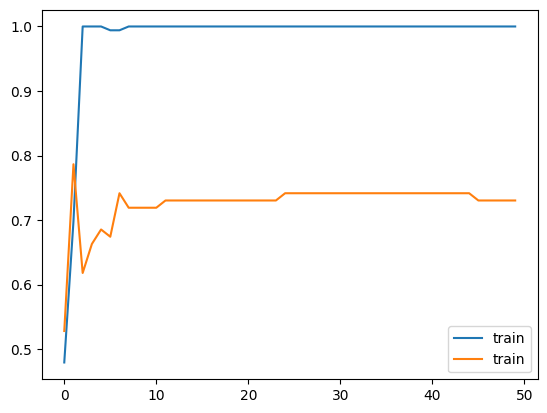

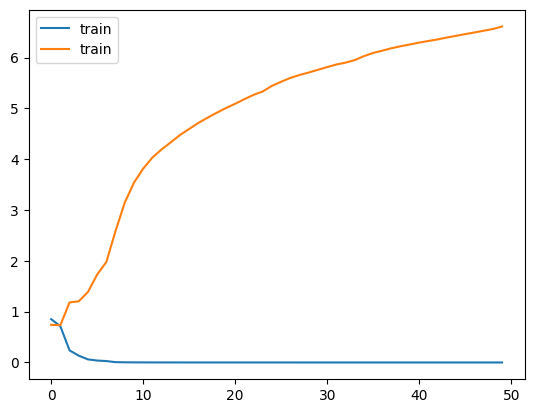

In [30]:
plt.plot(h1.history["accuracy"], label = "train")
plt.plot(h1.history["val_accuracy"], label = "train")
plt.legend()
plt.show()

plt.plot(h1.history["loss"], label = "train")
plt.plot(h1.history["val_loss"], label = "train")
plt.legend()
plt.show()

# prediction

In [31]:
pred = model1.predict(X_test)

idx = 30

print(pred[idx])
print(y_test_en.iloc[idx])

3/3 [==============================] - 0s 4ms/step
[3.5695854e-04 9.9856108e-01 1.0819236e-03]
crying     0
laugh      1
silence    0
Name: 30, dtype: uint8


# wav 데이터를 Conv1D로 특성 추출해 학습
- conv1d에 데이터 입력으로 넣기 위해 차원 추가

In [32]:
X_train.shape

(169, 30000)

In [33]:
# -1 (가장 뒷쪽)에 차원 추가
X_train = np.expand_dims(X_train, -1)
X_test = np.expand_dims(X_test, -1)

X_train.shape, X_test.shape

((169, 30000, 1), (89, 30000, 1))

# 신경망 설계

In [42]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D
from tensorflow.keras.layers import Dense, Dropout

model2 = Sequential()

model2.add(Conv1D(filters = 64, kernel_size = 3, activation = 'relu', input_shape = (30000, 1)))
model2.add(Conv1D(filters = 64, kernel_size = 3, activation = 'relu'))
model2.add(MaxPooling1D(pool_size = 3))
model2.add(Conv1D(filters = 128, kernel_size = 3, activation = 'relu'))
model2.add(Conv1D(filters = 128, kernel_size = 3, activation = 'relu'))
model2.add(GlobalMaxPooling1D())

model2.add(Dense(units = 3, activation  = 'softmax'))

In [43]:
model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 29998, 64)         256       
                                                                 
 conv1d_5 (Conv1D)           (None, 29996, 64)         12352     
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 9998, 64)          0         
 g1D)                                                            
                                                                 
 conv1d_6 (Conv1D)           (None, 9996, 128)         24704     
                                                                 
 conv1d_7 (Conv1D)           (None, 9994, 128)         49280     
                                                                 
 global_max_pooling1d (Glob  (None, 128)               0         
 alMaxPooling1D)                                      

In [44]:
model2.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [45]:
h2 = model2.fit(X_train, y_train_en, epochs = 50, batch_size = 32, validation_data = (X_test, y_test_en))

Epoch 1/50
6/6 [==============================] - 12s 509ms/step - loss: 1.0316 - accuracy: 0.4260 - val_loss: 0.9268 - val_accuracy: 0.5056
Epoch 2/50
6/6 [==============================] - 1s 157ms/step - loss: 0.9188 - accuracy: 0.5266 - val_loss: 0.8028 - val_accuracy: 0.7640
Epoch 3/50
6/6 [==============================] - 1s 157ms/step - loss: 0.8125 - accuracy: 0.6450 - val_loss: 0.6760 - val_accuracy: 0.8539
Epoch 4/50
6/6 [==============================] - 1s 189ms/step - loss: 0.6443 - accuracy: 0.8047 - val_loss: 0.5329 - val_accuracy: 0.7865
Epoch 5/50
6/6 [==============================] - 1s 188ms/step - loss: 0.4924 - accuracy: 0.8521 - val_loss: 0.4405 - val_accuracy: 0.7978
Epoch 6/50
6/6 [==============================] - 1s 159ms/step - loss: 0.4011 - accuracy: 0.8698 - val_loss: 0.4225 - val_accuracy: 0.8202
Epoch 7/50
6/6 [==============================] - 1s 164ms/step - loss: 0.3649 - accuracy: 0.8521 - val_loss: 0.4516 - val_accuracy: 0.7753
Epoch 8/50
6/6 [===

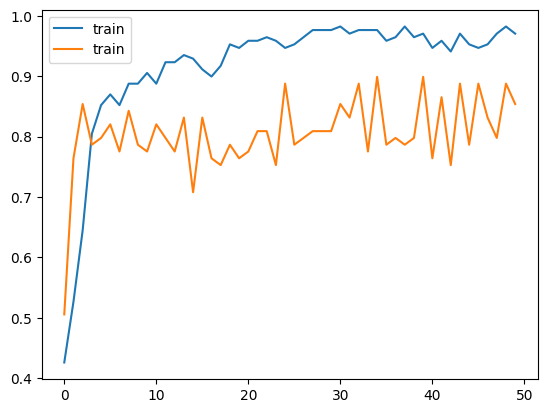

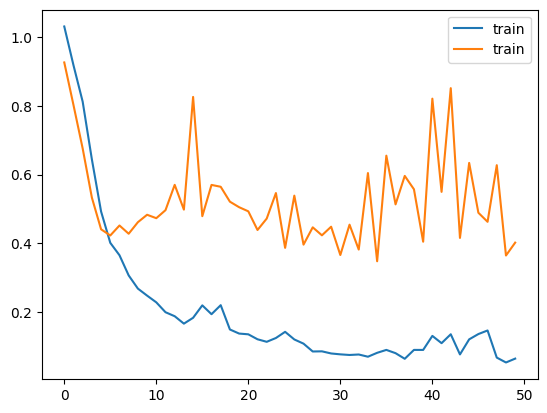

In [46]:
plt.plot(h2.history["accuracy"], label = "train")
plt.plot(h2.history["val_accuracy"], label = "train")
plt.legend()
plt.show()

plt.plot(h2.history["loss"], label = "train")
plt.plot(h2.history["val_loss"], label = "train")
plt.legend()
plt.show()

In [49]:
pred = model2.predict(X_test)

idx = 5

print(pred[idx])
print(y_test_en.iloc[idx])

3/3 [==============================] - 0s 72ms/step
[0.01519788 0.9758263  0.00897579]
crying     1
laugh      0
silence    0
Name: 5, dtype: uint8


# wav 데이터를 MFCC 로 변환하고 Conv2D로 학습

In [59]:
X_train = []
X_test = []
y_train = []
y_test = []

In [60]:
# 훈련 데이터에서 특성 데이터 (MFCC)와 라벨
for fname in os.listdir(TRAIN_DIR):
  # 파일명에서 라벨 분리
  label = fname.split(" ")[0]

  y_train.append(label)

  # wav 파일을 MFCC로 변환하여 같은 길이로 만들어 특성 데이터를 저장
  wav, sr = librosa.load(TRAIN_DIR + fname)

  # 멜스펙트럼 계산
  S = librosa.feature.melspectrogram(y = wav, sr = sr, n_mels = 128)

  # 로그 계산
  log_S = librosa.power_to_db(S, ref = np.max)

  # MFCC 변환
  mfcc_rs = librosa.feature.mfcc(S = log_S, n_mfcc = 20)

  # 같은 길이로 만들기
  pad_mfcc = pad2d(mfcc_rs, 40)

  X_train.append(pad_mfcc)

In [61]:
# 테스트 데이터에서 특성 데이터 (MFCC)와 라벨
for fname in os.listdir(TEST_DIR):
  # 파일명에서 라벨 분리
  label = fname.split(" ")[0]

  y_test.append(label)

  # wav 파일을 MFCC로 변환하여 같은 길이로 만들어 특성 데이터를 저장
  wav, sr = librosa.load(TEST_DIR + fname)

  # 멜스펙트럼 계산
  S = librosa.feature.melspectrogram(y = wav, sr = sr, n_mels = 128)

  # 로그 계산
  log_S = librosa.power_to_db(S, ref = np.max)

  # MFCC 변환
  mfcc_rs = librosa.feature.mfcc(S = log_S, n_mfcc = 20)

  # 같은 길이로 만들기
  pad_mfcc = pad2d(mfcc_rs, 40)

  X_test.append(pad_mfcc)

In [62]:
len(X_train), len(X_test)

(169, 89)

# 특성 데이터는 리스트 -> 배열
# 라벨 데이터는 원핫인코딩

In [63]:
import numpy as np
import pandas as pd

X_train = np.array(X_train)
X_test = np.array(X_test)
y_train_en = pd.get_dummies(y_train)
y_test_en = pd.get_dummies(y_test)

X_train.shape, y_train_en.shape, X_test.shape, y_test_en.shape

((169, 20, 40), (169, 3), (89, 20, 40), (89, 3))

# 색상 차원 추가

In [64]:
X_train_ex = np.expand_dims(X_train, -1)
X_test_ex = np.expand_dims(X_test, -1)

X_train_ex.shape, X_test_ex.shape

((169, 20, 40, 1), (89, 20, 40, 1))

# 신경망 설계

In [70]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.layers import Flatten, Dense, Dropout

model3 = Sequential()

model3.add(Conv2D(filters = 32, kernel_size = (3, 3), activation = 'relu', input_shape = (20, 40, 1)))
model3.add(GlobalMaxPooling2D())

model3.add(Dense(units = 128, activation = 'relu'))
model3.add(Dropout(0.2))
model3.add(Dense(units = 64, activation = 'relu'))
model3.add(Dropout(0.2))
model3.add(Dense(units = 32, activation = 'relu'))
model3.add(Dropout(0.2))

model3.add(Dense(units = 3, activation = 'softmax'))

model3.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 18, 38, 32)        320       
                                                                 
 global_max_pooling2d_1 (Gl  (None, 32)                0         
 obalMaxPooling2D)                                               
                                                                 
 dense_11 (Dense)            (None, 128)               4224      
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_12 (Dense)            (None, 64)                8256      
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                      

In [71]:
model3.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [72]:
h3 = model3.fit(X_train, y_train_en, epochs = 50, batch_size = 32, validation_data = (X_test, y_test_en))

Epoch 1/50
6/6 [==============================] - 2s 51ms/step - loss: 45.0185 - accuracy: 0.2012 - val_loss: 9.2725 - val_accuracy: 0.4270
Epoch 2/50
6/6 [==============================] - 0s 12ms/step - loss: 15.8994 - accuracy: 0.4142 - val_loss: 9.2343 - val_accuracy: 0.4270
Epoch 3/50
6/6 [==============================] - 0s 13ms/step - loss: 13.0662 - accuracy: 0.3550 - val_loss: 13.6748 - val_accuracy: 0.4270
Epoch 4/50
6/6 [==============================] - 0s 11ms/step - loss: 10.2023 - accuracy: 0.3905 - val_loss: 5.3463 - val_accuracy: 0.4270
Epoch 5/50
6/6 [==============================] - 0s 11ms/step - loss: 5.8370 - accuracy: 0.3787 - val_loss: 0.8518 - val_accuracy: 0.7528
Epoch 6/50
6/6 [==============================] - 0s 11ms/step - loss: 4.3175 - accuracy: 0.4024 - val_loss: 1.2652 - val_accuracy: 0.4157
Epoch 7/50
6/6 [==============================] - 0s 12ms/step - loss: 4.4759 - accuracy: 0.3077 - val_loss: 1.3775 - val_accuracy: 0.5281
Epoch 8/50
6/6 [======

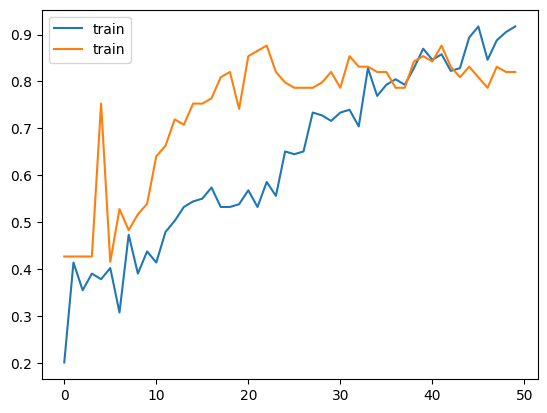

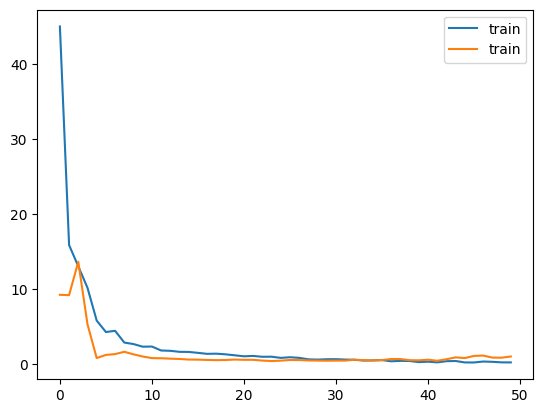

In [73]:
plt.plot(h3.history["accuracy"], label = "train")
plt.plot(h3.history["val_accuracy"], label = "train")
plt.legend()
plt.show()

plt.plot(h3.history["loss"], label = "train")
plt.plot(h3.history["val_loss"], label = "train")
plt.legend()
plt.show()

In [74]:
pred = model3.predict(X_test)

idx = 5

print(pred[idx])
print(y_test_en.iloc[idx])

3/3 [==============================] - 0s 4ms/step
[8.4931776e-02 7.3152798e-04 9.1433674e-01]
crying     1
laugh      0
silence    0
Name: 5, dtype: uint8
